# 0 - To start

## Some libraries to load

In [1]:
import numpy as np
from math import pi, gcd
try:
    from qiskit import *
    from matplotlib.pyplot import plot,show
except:
    ! python -m pip install matplotlib pylatexenc
    ! python -m pip install qiskit
from qiskit import *
from qiskit.circuit import *
from qiskit.extensions import *
from qiskit.circuit.library import *
from qiskit.extensions.simulator.snapshot import snapshot
from qiskit.quantum_info.operators import Operator
from qiskit.extensions.simulator.snapshot import snapshot
from qiskit.compiler import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
from scipy import optimize
from matplotlib.pyplot import plot,show
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

## A few useful functions

- `nat2bl` : from a natural number to a list of `0` and `1` (low-end bit on the right)
- `nat2bs` : from a natural number to a string such as `"010010011"`
- `bl2bs` : from a list to a string
- ... and all of the functions in the other direction.

In [2]:
def nat2bl(pad,n):
    if n == 0 :
        return [0 for i in range(pad)]
    elif n % 2 == 1:
        r = nat2bl(pad-1,(n-1)//2)
        r.append(1)
        return r
    else:
        r = nat2bl(pad-1,n//2)
        r.append(0)
        return r

for i in range(16):
    print(nat2bl(5,i))

[0, 0, 0, 0, 0]
[0, 0, 0, 0, 1]
[0, 0, 0, 1, 0]
[0, 0, 0, 1, 1]
[0, 0, 1, 0, 0]
[0, 0, 1, 0, 1]
[0, 0, 1, 1, 0]
[0, 0, 1, 1, 1]
[0, 1, 0, 0, 0]
[0, 1, 0, 0, 1]
[0, 1, 0, 1, 0]
[0, 1, 0, 1, 1]
[0, 1, 1, 0, 0]
[0, 1, 1, 0, 1]
[0, 1, 1, 1, 0]
[0, 1, 1, 1, 1]


In [3]:
def bl2nat(s):
    if len(s) == 0:
        return 0
    else:
        a = s.pop()
        return (a + 2*bl2nat(s))

def bl2bs(l):
    if len(l) == 0:
        return ""
    else:
        a = l.pop()
        return (bl2bs(l) + str(a))

def nat2bs(pad,i):
    return bl2bs(nat2bl(pad,i))

def bs2bl(s):
    l = []
    for i in range(len(s)):
        l.append(int(s[i]))
    return l

def bs2nat(s):
    return bl2nat(bs2bl(s))


print(nat2bs(10,17))
print(bs2nat("0011010"))

0000010001
26


## Small practice

To start, check that when we measure $\frac1{\sqrt2}(|000\rangle+|111\rangle)$ we indeed get 000 and 111 about the same number of times. 

In [4]:
# Generating the circuit

q = QuantumRegister(3)   # We need 3 qubits..
c = ClassicalRegister(3) # ... and 3 bits to store the results
qc = QuantumCircuit(q,c) # the circuit !

To initialize the state to $\frac1{\sqrt2}(|000\rangle+|111\rangle)$ from the initial state $|000\rangle$:
 1) We first put a Hadamard gate on the first qubit to get $\frac1{\sqrt2}(|000\rangle+|100\rangle)$.
 2) We then apply a CNOT gate to the second qubit controled by the first qubit to get $\frac1{\sqrt2}(|000\rangle+|110\rangle)$
 3) Finaly we do the same for the last qubit to get the desired state.

In [5]:
# TODO : realize the circ that build 1/sqrt(2)(|000>+|111>)

qc.h(q[0])
qc.cnot(q[0],q[1])
qc.cnot(q[0],q[2])

qc.draw()

┌───┐          
q0_0: ┤ H ├──■────■──
      └───┘┌─┴─┐  │  
q0_1: ─────┤ X ├──┼──
           └───┘┌─┴─┐
q0_2: ──────────┤ X ├
                └───┘
c0_0: ═══════════════
                     
c0_1: ═══════════════
                     
c0_2: ═══════════════

We observe the superposition in the following cell.

We correctly get the desired state $\frac1{\sqrt2}(|000\rangle+|111\rangle)$.

In [6]:
# TODO : measure and check

backend = Aer.get_backend('statevector_simulator')
job = execute(qc, backend=backend, shots=1, memory=True)
job_result = job.result()
print(job_result.get_statevector(qc))

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))


If everything works, you are ready to start.

# 1 - Introduction

In this lab session we are going to code the heart of Shor's algorithm: the circuit making it possible to find the period of the function

$$
x \mapsto a^x mod N.
$$

We then need first to code QPE, then the oracle computing the multiplication modulo, then combined everything.

**Objective** : Only to convince yourself that the number we are looking for can be recovered from the final distribution.

Let's go.

# 2 - QPE

We've seen the QPE algorithm in the course, and you checked it worked with 3 qubits. Here we are going to implement it with the following unitary:

In [7]:
U = UnitaryGate(
    Operator([[1,0,0,0],
              [0,1,0,0],
              [0,0,1,0],
              [0,0,0,np.exp(pi*2j*(6/8))]]), label="U")

## Questions 

###  Q 2.1 Math questions

* What is doing this operator ? (`2j` is in Python the complex number $2\cdot i$)
* On how many qubits does it act ?
* What are its eigenvalues/eigenvectors ?
* For each eigenvector, what should QPE return with 3 bits of precisions, as seen in the course ?

### Answers to 2.1)

This operator dephases the state $|11\rangle$ by a phase $\omega = \frac{6}{8}$ and lets other state in the basis unaffected.

It acts on 2 qubits as it is of size $4 = 2^2$.

The eigen vectors are:
 - $|11\rangle$ with an eigen value of $e^{2\pi i\frac{6}{8}}$.
 - The eigen space of basis $\left\{|00\rangle,\;|01\rangle,\;|10\rangle\right\}$ with an eigen value of $1$.
 
The QPE algorithme should return (with 3 bits of precision):
 - A phase of $\omega = 0$ for the eigen space of basis $\left\{|00\rangle,\;|01\rangle,\;|10\rangle\right\}$.
 - A phase of $\omega = 0.11$ (in bynary) for the eigen vector $|11\rangle$, which is equal to $\frac{6}{8} = 0.75$ (in decimal).

### Q 2.2 Implementing QPE

Below a template to fill in for
- realize QPE with 3 bits of precision.
- on the eigenvector of non-trivial eigenvalue

We initialized a quantum circuit with 3 registers:
 - `eig` for storing the eigenvalues
 - `phi` for storing the eigenvector
 - `ceig` for storing the result of the measurement of the eigenvalue-register.
 
Note that we only need to measure the eigenvalues!

What you will need:
 - `QFT(size)` build for you a QFT on `size` qubits.
 - `U.control()` for controlling a gate `U`. The control qubit should be placed first in the list of wires.
 - `U.inverse()` for the inverse of the gate `U`.
 - `U.power(n)` add `p` times `U` on the circuit.
 - `qc.append(U, list_of_qubits)` applies the gate `U` on the list of qubits.
 - Beware : `phi` (for instance) is not a list but a register. So if you want to concatenate it with something else, you first have to make a list out of it with `list(phi)`.

In [8]:
size_eig = 3
size_phi = 2

eig  = QuantumRegister(size_eig, name="eig")
phi  = QuantumRegister(size_phi, name="phi")
ceig = ClassicalRegister(size_eig, name="ceig")
qc   = QuantumCircuit(eig,phi,ceig)


# To fill in

# define a function to generate the QPE for later
def generate_QPE(U, eig, phi, ceig, qc):
    size_eig = len(eig)
    size_phi = len(phi)

    # prepare eig
    for q_eig in eig:
        qc.h(q_eig)
        
    # control-U^n gates
    for i in range(size_eig):
        C_Un = U.power(2**i).control()
        qc.append(C_Un, [eig[i]] + phi[:])
        
    # QFT gate
    QFT_1 = QFT(size_eig).inverse()
    qc.append(QFT_1, eig)
    # meusurement
    qc.measure(eig, ceig)
    
# prepare eigen vector
qc.x(phi[0])
qc.x(phi[1])

# generate QPE circuit
generate_QPE(U, eig, phi, ceig, qc)
    
qc.draw()

# First, make sure that the drawing is OK.

┌───┐                                          ┌───────┐┌─┐      
 eig_0: ┤ H ├──────■───────────────────────────────────┤0      ├┤M├──────
        ├───┤      │                                   │       │└╥┘┌─┐   
 eig_1: ┤ H ├──────┼─────────────■─────────────────────┤1 IQFT ├─╫─┤M├───
        ├───┤      │             │                     │       │ ║ └╥┘┌─┐
 eig_2: ┤ H ├──────┼─────────────┼─────────────■───────┤2      ├─╫──╫─┤M├
        ├───┤┌─────┴──────┐┌─────┴──────┐┌─────┴──────┐└───────┘ ║  ║ └╥┘
 phi_0: ┤ X ├┤0           ├┤0           ├┤0           ├──────────╫──╫──╫─
        ├───┤│  unitary^1 ││  unitary^2 ││  unitary^4 │          ║  ║  ║ 
 phi_1: ┤ X ├┤1           ├┤1           ├┤1           ├──────────╫──╫──╫─
        └───┘└────────────┘└────────────┘└────────────┘          ║  ║  ║ 
ceig_0: ═════════════════════════════════════════════════════════╩══╬══╬═
                                                                    ║  ║ 
ceig_1: ════════════════════════════════════════════════════════════╩══╬═
                                                                       ║ 
ceig_2: ═══════════════════════════════════════════════════════════════╩═

In [9]:
# Then run the backend !

backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
job.result().get_counts(qc)

{'110': 1000}

### Q 2.3 Analysis

- Is it the expected result ?
- Change the $\frac68$ of the phase of $U$: use $\frac18$, then $\frac28$... Is QPE returning the correct answer?
- Change the precision : use $4$ qubits for `eig`, and change the fraction in the phase of $U$ to $\frac{10}{16}$ : is QPE indeed returning $10$ in binary ?
- Move to $5$ bits of précision: is it still working ?

### Answers to 2.3)

We corretly get $|110\rangle$ with a probability of $1$ as it $110$ corresponds (in binary) to the phase $\omega = \frac{6}{8}$.

In [10]:
for i in range(1, 8):
    size_eig = 3
    size_phi = 2

    eig  = QuantumRegister(size_eig, name="eig")
    phi  = QuantumRegister(size_phi, name="phi")
    ceig = ClassicalRegister(size_eig, name="ceig")
    qc   = QuantumCircuit(eig,phi,ceig)

    U = UnitaryGate(
        Operator([[1,0,0,0],
                  [0,1,0,0],
                  [0,0,1,0],
                  [0,0,0,np.exp(pi*2j*(i/8))]]), label="U")

    # prepare eigen vector
    qc.x(phi[0])
    qc.x(phi[1])

    # generate QPE circuit
    generate_QPE(U, eig, phi, ceig, qc)

    # Then run the backend !
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=1000)
    print(f"Results for a phase w={i}/8: {job.result().get_counts(qc)}")

Results for a phase w=1/8: {'001': 1000}
Results for a phase w=2/8: {'010': 1000}
Results for a phase w=3/8: {'011': 1000}
Results for a phase w=4/8: {'100': 1000}
Results for a phase w=5/8: {'101': 1000}
Results for a phase w=6/8: {'110': 1000}
Results for a phase w=7/8: {'111': 1000}


For each phase $\omega \in \left\{ \frac{1}{8},\;\frac{2}{8},\;...\frac{7}{8}\right\}$ we get the correct phase with a probability $1$ (as these phase can be written exactly with 3 bits).

In [11]:
for size_eig in [4, 5]:
    size_phi = 2

    eig  = QuantumRegister(size_eig, name="eig")
    phi  = QuantumRegister(size_phi, name="phi")
    ceig = ClassicalRegister(size_eig, name="ceig")
    qc   = QuantumCircuit(eig,phi,ceig)

    U = UnitaryGate(
        Operator([[1,0,0,0],
                  [0,1,0,0],
                  [0,0,1,0],
                  [0,0,0,np.exp(pi*2j*(10/16))]]), label="U")

    # prepare eigen vector
    qc.x(phi[0])
    qc.x(phi[1])

    # generate QPE circuit
    generate_QPE(U, eig, phi, ceig, qc)

    # Then run the backend !
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(qc, backend, shots=1000)
    print(f"Results for a phase w=10/16 and {size_eig} bits: {job.result().get_counts(qc)}")

Results for a phase w=10/16 and 4 bits: {'1010': 1000}
Results for a phase w=10/16 and 5 bits: {'10100': 1000}


For a phase $\omega = \frac{10}{16}$ we correctly get 1010 (10 in binary aka $\frac{10}{16}$).

The algorithm also works for 5 bits as seend above.

### Q 2.4 To go further

We saw that the circuit of QPE has no problem with a superposition of eigenvectors. Try to change the initialization of `phi` with 
$$
\frac1{\sqrt2}(|\phi_1\rangle + |\phi_2\rangle),
$$
two eigenvectors of $U$ (one with trivial eigenvalue, the other one non-trivial).

Also measure the register `phi` at the end of the circuit, and analyze the result: do you recover what we saw in class ?

### Answers to 2.3)

In [12]:
size_eig = 3
size_phi = 2

eig  = QuantumRegister(size_eig, name="eig")
phi  = QuantumRegister(size_phi, name="phi")
ceig = ClassicalRegister(size_eig, name="ceig")
qc   = QuantumCircuit(eig,phi,ceig)

U = UnitaryGate(
    Operator([[1,0,0,0],
              [0,1,0,0],
              [0,0,1,0],
              [0,0,0,np.exp(pi*2j*(6/8))]]), label="U")

# prepare eigen vector
qc.x(phi[0])
qc.h(phi[1])

# generate QPE circuit
generate_QPE(U, eig, phi, ceig, qc)

# Then run the backend !
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
print(job.result().get_counts(qc))

{'110': 499, '000': 501}


Here we get $|000\rangle$ (corresponding to a phase $\omega = 0$) with a probability $P \approx 0.5$, and $|110\rangle$ (correctly corresponding to the non trivial phase $\omega = \frac{6}{8}$) with a probability $P \approx 0.5$.

We get a superposition of the correct results with the same probability as the proportion of the two eigen vectors in the initial state.

# 3 - Oracle synthesis

The function $f : x\mapsto (a^p\cdot x)~mod~N$ is a bijection of $\{0...N-1\}$ to $\{0...N-1\}$ if $a$ and $N$ are co-primes. 

In this case, we can consider $f$ as a unitary operator acting on a Hilbert space of dimension $N$.
One can then consider $f$ as a unitary acting on a register of qubits, provided that $N$ is a power of $2$.

This is a bit limited : we want to be able to consider arbitrary numbers $N$. We then instead consider the function:
$$
Mult_{a^p~mod~N} : x\mapsto 
\left\{
\begin{array}{ll}
(a^p\cdot x)~mod~N & \text{si }x < N
\\
x & \text{si} N \leq x < 2^n
\end{array}\right.
$$
provided that $N<2^n$.

This new function $Mult_{a^p~mod~N}$ is indeed a bijection of $\{0..2^n\}$: we are going to implement this one instead. Here, we are making something simple, using the automated circuit synthesis of QisKit. It is not the most efficient, but it is the easiest for our purpose.

To clarify what is expected, let us consider the code for $Mult_{2^3~mod~13}$, that is, $Mult_{8~mod~13}$. To store all of the numbers from $0$ to $12$ we need $4$ bits. The table for the operation $Mult_{8~mod~13}$ is as follows. We first write it using decimal numbers, then with the binary decomposition. Note how starting from $x=13$ we are just padding to complete to $15 = 2^4-1$.


| x  |  result  || x (binary) | result (binary) |
| -- | -------- || ---------- | --------------- |
| 0  |  0       || 0000       | 0000            |
| 1  |  8       || 0001       | 1000            |
| 2  |  3       || 0010       | 0011            |
| 3  |  11      || 0011       | 1011            |
| 4  |  6       || 0100       | 0110            |
| 5  |  1       || 0101       | 0001            |
| 6  |  9       || 0110       | 1001            |
| 7  |  4       || 0111       | 0100            |
| 8  |  12      || 1000       | 1100            |
| 9  |  7       || 1001       | 0111            |
| 10 |  2       || 1010       | 0010            |
| 11 |  10      || 1011       | 1010            |
| 12 |  5       || 1100       | 0101            |
| -- | --       || ----       | ----            |
| 13 | 13       || 1101       | 1101            |
| 14 | 14       || 1110       | 1110            |
| 15 | 15       || 1111       | 1111            |

The corresponding matrix is then

$$
\begin{array}{ccccccccccccc|ccc}
1&0&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&1&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&1&0&0&0&0&0\\
0&0&1&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&1&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&1&0&0&0\\
0&0&0&0&1&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&1&0&0&0&0&0&0\\
0&1&0&0&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&1&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&0&0&0&1&0&0&0&0\\
0&0&0&1&0&0&0&0&0&0&0&0&0&0&0&0\\
0&0&0&0&0&0&0&0&1&0&0&0&0&0&0&0\\\hline
0&0&0&0&0&0&0&0&0&0&0&0&0&1&0&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&1&0\\
0&0&0&0&0&0&0&0&0&0&0&0&0&0&0&1\\
\end{array}
$$

The top-left block corresponds to the permutation matrix : $|0010\rangle$ is for instance sent to $|0011\rangle$ (i.e. $2$ is sent to $3$). The bottom-right block corresponds to the padding with identity, to build an unitary matrix defined on the whole space.


## Questions

### Q 3.1 Operator for the multiplication modulo.

- Complete the following code so that `M` is a matrix implementing the bijection $Mult_{a^p~mod~N}$.
- Test it with the code below it, with $a = 1, 3, 6, 11, 15$.

In [13]:
# a, p, N et n are as above
# we compute x |--> a^p * x mod N, seen as an operator on C^{2^n}

def gateMult(a,p,N,n):
    nn = 2 ** n
    M = np.zeros((nn, nn))

    # FILL IN M WITH SOMETHING
    # fill values
    for x in range(N):
        res = (x*a**p)%N
        M[res][x] = 1.0
    # padding
    for x in range(N, nn):
        M[x][x] = 1

    U = Operator(M)
    return UnitaryGate(U)

In [14]:
# Code to test the circuit computing (x * a ^ p) mod N, on n qubits

# VALUES TO POSSIBLY CHANGE
# BEWARE to keep x and N < 2^n
x = 3
a = 2
p = 4
N = 11
n = 4

# TEST TO NOT CHANGE

phi = QuantumRegister(n)
cphi = ClassicalRegister(n)

qc = QuantumCircuit(phi,cphi)
vl = nat2bl(n,x)
print(f"Input : {str(vl)} (= {x} en décimal)")
vl.reverse() # Changement de la place du bit de poid faible
for i in range(len(vl)):
    if vl[i] == 1:
        qc.x(phi[i])

qc.append(gateMult(a,p,N,n),list(phi))
qc.measure(phi,cphi)

backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
d = job.result().get_counts(qc)

assert(len(d) == 1)
s =  list(d.keys())[0]

if x < 11:
    print(f"Correct answer should be {x} * {a}^{p} mod {N} = {(x*(a ** p)) % N}")
else:
    print(f"We are above {N} so this should be the identity")
print(f"The circuit answer: {s} (= {bs2nat(s)} in decimal)")

# If you run it, it should print a log of what is expected and what is indeed computed.

Input : [0, 0, 1, 1] (= 3 en décimal)
Correct answer should be 3 * 2^4 mod 11 = 4
The circuit answer: 0100 (= 4 in decimal)


### Q 3.2 Size of generated circuit

Qiskit packages the circuit it makes out of the matrix inside a nice and clean box. What is the concrete size of the generated circuit ? Let us test it to see.

- TODO : modify the code below to compute the size of the circuits generated by QisKit for the following matrices:
(you can write next to each bullet point the answer you get).
  * `gateMult(3,3,2 ** 2,2)` - 1 gate
  * `gateMult(3,3,2 ** 3,3)` - 54 gates
  * `gateMult(3,3,2 ** 4,4)` - 253 gates
  * `gateMult(3,3,2 ** 5,5)` - 1139 gates
  * `gateMult(3,3,2 ** 6,6)` - 4760 gates
  * `gateMult(3,3,2 ** 7,7)` - 19417 gates

In [15]:
n = 3
q = QuantumRegister(n)

qc = QuantumCircuit(q)
qc.h(q[0])
qc.x(q[1])
qc.ccx(q[0],q[1],q[2]) # a Toffoli gate, for the sake of it.

# Our circuit is not necessarily in elementary unitary gates.
# Let us unfold them before counting.

pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
new_circ = pm.run(qc)

count = new_circ.count_ops()
count

OrderedDict([('u', 11), ('cx', 6)])

In [16]:
r = 0
for k in count:
    r += count[k]
print(f"For {n} qubits there are {r} gates in total.")

For 3 qubits there are 17 gates in total.


### Answers to 3.2)

In [17]:
for n in range(2, 8):
    q = QuantumRegister(n)

    qc = QuantumCircuit(q)
    
    qc.append(gateMult(3,3,2**n,n), q)

    # Our circuit is not necessarily in elementary unitary gates.
    # Let us unfold them before counting.
    
    # basis of gates
    basis = ['u', 'cx']

    # unfold
    pass_ = Unroller(basis)
    pm = PassManager(pass_)
    new_circ = pm.run(qc)
    
    # count and print gates
    count = new_circ.count_ops()
    r = 0
    for k in count:
        r += count[k]
    print(f"circuit gateMult(3,3,2**{n},{n}) countains {r} gates")

circuit gateMult(3,3,2**2,2) countains 5 gates
circuit gateMult(3,3,2**3,3) countains 61 gates
circuit gateMult(3,3,2**4,4) countains 296 gates
circuit gateMult(3,3,2**5,5) countains 1342 gates
circuit gateMult(3,3,2**6,6) countains 5635 gates
circuit gateMult(3,3,2**7,7) countains 23044 gates


### Q 3.3 Analysis

- What is the complexity of the circuit size in term of number of qubits ?
- If it is doable for small `n`, is it realisitic for large sizes ?
- What alternate method could you suggest, with what potential drawbacks ?


### Answers to 3.3)

We observe a complexity that seems to be exponential in the number of qubit (more precisly $n$ qubits the number of gates seems to be $O(4^{n})$).

This complexity is very restrictive for large sizes.

# 4 - Plugging everything together : Shor

We are now ready to realize Shor's algorithm

## Questions

### Q 4.1 The circuit

Realize the circuit:
- Copy-paste the code of QPE, with 4 qbits of precision for `eig`
- Introduce our home-made unitary : choose 5 qbits pour `phi`
- Place `phi` in the state corresponding to the integer $1$ in decimal (beware of the position of the low-end bit)


In [18]:
a = 7
N = 30
size_eig = 4
size_phi = 5

eig  = QuantumRegister(size_eig, name="eig")
phi  = QuantumRegister(size_phi, name="phi")
ceig = ClassicalRegister(size_eig, name="ceig")
qc   = QuantumCircuit(eig,phi,ceig)

U = gateMult(a, 1, N, size_phi)

# prepare eigen vector
qc.x(phi[-2])

# generate QPE circuit
generate_QPE(U, eig, phi, ceig, qc)

# At the end, we draw the circuit to check that everyting is in order.
qc.draw()

┌───┐                                                        ┌───────┐»
 eig_0: ┤ H ├──────■─────────────────────────────────────────────────┤0      ├»
        ├───┤      │                                                 │       │»
 eig_1: ┤ H ├──────┼─────────────■───────────────────────────────────┤1      ├»
        ├───┤      │             │                                   │  IQFT │»
 eig_2: ┤ H ├──────┼─────────────┼─────────────■─────────────────────┤2      ├»
        ├───┤      │             │             │                     │       │»
 eig_3: ┤ H ├──────┼─────────────┼─────────────┼─────────────■───────┤3      ├»
        └───┘┌─────┴──────┐┌─────┴──────┐┌─────┴──────┐┌─────┴──────┐└───────┘»
 phi_0: ─────┤0           ├┤0           ├┤0           ├┤0           ├─────────»
             │            ││            ││            ││            │         »
 phi_1: ─────┤1           ├┤1           ├┤1           ├┤1           ├─────────»
             │            ││            ││            ││            │         »
 phi_2: ─────┤2 unitary^1 ├┤2 unitary^2 ├┤2 unitary^4 ├┤2 unitary^8 ├─────────»
        ┌───┐│            ││            ││            ││            │         »
 phi_3: ┤ X ├┤3           ├┤3           ├┤3           ├┤3           ├─────────»
        └───┘│            ││            ││            ││            │         »
 phi_4: ─────┤4           ├┤4           ├┤4           ├┤4           ├─────────»
             └────────────┘└────────────┘└────────────┘└────────────┘         »
ceig_0: ══════════════════════════════════════════════════════════════════════»
                                                                              »
ceig_1: ══════════════════════════════════════════════════════════════════════»
                                                                              »
ceig_2: ══════════════════════════════════════════════════════════════════════»
                                                                              »
ceig_3: ══════════════════════════════════════════════════════════════════════»
                                                                              »
«        ┌─┐         
« eig_0: ┤M├─────────
«        └╥┘┌─┐      
« eig_1: ─╫─┤M├──────
«         ║ └╥┘┌─┐   
« eig_2: ─╫──╫─┤M├───
«         ║  ║ └╥┘┌─┐
« eig_3: ─╫──╫──╫─┤M├
«         ║  ║  ║ └╥┘
« phi_0: ─╫──╫──╫──╫─
«         ║  ║  ║  ║ 
« phi_1: ─╫──╫──╫──╫─
«         ║  ║  ║  ║ 
« phi_2: ─╫──╫──╫──╫─
«         ║  ║  ║  ║ 
« phi_3: ─╫──╫──╫──╫─
«         ║  ║  ║  ║ 
« phi_4: ─╫──╫──╫──╫─
«         ║  ║  ║  ║ 
«ceig_0: ═╩══╬══╬══╬═
«            ║  ║  ║ 
«ceig_1: ════╩══╬══╬═
«               ║  ║ 
«ceig_2: ═══════╩══╬═
«                  ║ 
«ceig_3: ══════════╩═
«

In [19]:
# Then we can run things.
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
d = job.result().get_counts(qc)
d

{'0000': 233, '0100': 281, '1000': 243, '1100': 243}

### Q 4.2 Results

We get a distribution of résults in the form of a dictionary.
 - each key is morally a fraction $s/r$, for $r$ the order of $a$ mod $N$
 - it is only written with some precision (depending on the chosen number of bits), and it is written in binary.
 - The value associated to a key is the number of times we found the corresponding key.
 
Below is a code drawing a graph out of `d` with horizontal axis the key, in decimal, and in vertical axis the number of times we found it.

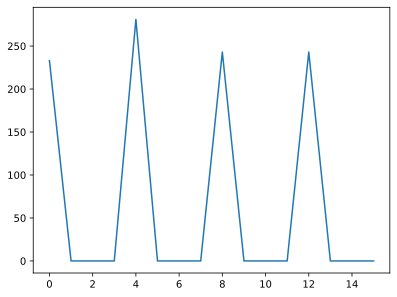

In [20]:
pts = []
for i in range(2**size_eig):
    k = nat2bs(size_eig,i)
    if k in d:
        pts.append((i,d[k]))
    else:
        pts.append((i,0))

def snd(a):
    (a1,a2) = a
    return a1
        
pts.sort(key = snd)

xs = []
ys = []
for i in range(len(pts)):
    (x,y) = pts[i]
    xs.append(x)
    ys.append(y)
plot(xs,ys)

### Q 4.3 Analysis

- What is the order $r$ of $a$ mod $N$ (here $7$ mod $30$) ?
- On the drawing, where are we supposed to see the values $\frac{s}{r}$ ? The horizontal axis is graded with integers... To what real numbers between 0 and 1 these correspond to ?
- Can you infer from the graph the value of $r$ ? Where do you see it on the graph ?
- Change a and N respectively to 20 and 29. Can you read the value $r$ ? Is it correct ?
- The drawing is not very precise... How to make it better ? Try it !
- Is it still working if you change the value of `a` and/or `N` to other values ? Beware not to use too large values for`N`... To get some inspiration, below is the list of possibilities up to 31.

**BEWARE** Make sure to only consider coprimes `a` and `N`.

In [21]:
for N in range(3,32):
    for a in range(2,N):
        if gcd(a,N) == 1:
            for p in range(1,N):
                if (a ** p) % N == 1:
                    break
            print(f"Order of {a} mod {N}: {p}")

Order of 2 mod 3: 2
Order of 3 mod 4: 2
Order of 2 mod 5: 4
Order of 3 mod 5: 4
Order of 4 mod 5: 2
Order of 5 mod 6: 2
Order of 2 mod 7: 3
Order of 3 mod 7: 6
Order of 4 mod 7: 3
Order of 5 mod 7: 6
Order of 6 mod 7: 2
Order of 3 mod 8: 2
Order of 5 mod 8: 2
Order of 7 mod 8: 2
Order of 2 mod 9: 6
Order of 4 mod 9: 3
Order of 5 mod 9: 6
Order of 7 mod 9: 3
Order of 8 mod 9: 2
Order of 3 mod 10: 4
Order of 7 mod 10: 4
Order of 9 mod 10: 2
Order of 2 mod 11: 10
Order of 3 mod 11: 5
Order of 4 mod 11: 5
Order of 5 mod 11: 5
Order of 6 mod 11: 10
Order of 7 mod 11: 10
Order of 8 mod 11: 10
Order of 9 mod 11: 5
Order of 10 mod 11: 2
Order of 5 mod 12: 2
Order of 7 mod 12: 2
Order of 11 mod 12: 2
Order of 2 mod 13: 12
Order of 3 mod 13: 3
Order of 4 mod 13: 6
Order of 5 mod 13: 4
Order of 6 mod 13: 12
Order of 7 mod 13: 12
Order of 8 mod 13: 4
Order of 9 mod 13: 3
Order of 10 mod 13: 6
Order of 11 mod 13: 12
Order of 12 mod 13: 2
Order of 3 mod 14: 6
Order of 5 mod 14: 6
Order of 9 mod 14: 

### Answers to Q 4.3)

The order of a mod N is 4.

We should see the value $\frac{s}{r}$ in the registers, with r being the number of peaks (of different values of $\frac{s}{r}$). The values on the horizontal axis $i$ (which are integers) would correspond to a real number $i.2^{-n_{phi}}$ with $n_{phi}$ being the number of qubits for the phase.

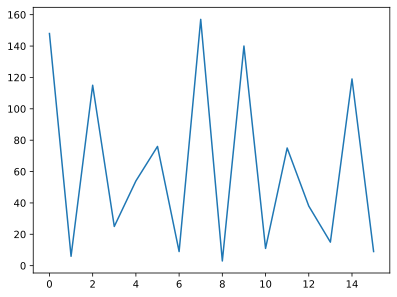

In [22]:
a = 20
N = 29
size_eig = 4
size_phi = 5

eig  = QuantumRegister(size_eig, name="eig")
phi  = QuantumRegister(size_phi, name="phi")
ceig = ClassicalRegister(size_eig, name="ceig")
qc   = QuantumCircuit(eig,phi,ceig)

U = gateMult(a, 3, N, size_phi)

# prepare eigen vector
qc.x(phi[-2])

# generate QPE circuit
generate_QPE(U, eig, phi, ceig, qc)

# Then we can run things.
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
d = job.result().get_counts(qc)

pts = []
for i in range(2**size_eig):
    k = nat2bs(size_eig,i)
    if k in d:
        pts.append((i,d[k]))
    else:
        pts.append((i,0))
        
pts.sort(key = snd)
xs = []
ys = []
for i in range(len(pts)):
    (x,y) = pts[i]
    xs.append(x)
    ys.append(y)
plot(xs,ys)

The order of 20 mod 29 is 7, which we can't read on this figure. The reason we can't read it is because the peaks overlap, as the different values of $\frac{s}{r}$ are too close with only $2^5$ possible registers.

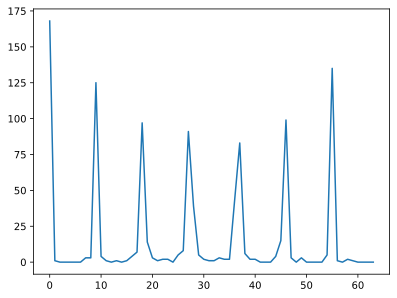

In [23]:
a = 20
N = 29
size_eig = 6
size_phi = 5

eig  = QuantumRegister(size_eig, name="eig")
phi  = QuantumRegister(size_phi, name="phi")
ceig = ClassicalRegister(size_eig, name="ceig")
qc   = QuantumCircuit(eig,phi,ceig)

U = gateMult(a, 3, N, size_phi)

# prepare eigen vector
qc.x(phi[-2])

# generate QPE circuit
generate_QPE(U, eig, phi, ceig, qc)

# Then we can run things.
backend = BasicAer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
d = job.result().get_counts(qc)

pts = []
for i in range(2**size_eig):
    k = nat2bs(size_eig,i)
    if k in d:
        pts.append((i,d[k]))
    else:
        pts.append((i,0))
        
pts.sort(key = snd)
xs = []
ys = []
for i in range(len(pts)):
    (x,y) = pts[i]
    xs.append(x)
    ys.append(y)
plot(xs,ys)

With 6 qubits instead of 4, we can clearly see the 7 peaks for a=20 and N=29 which corresponds to the order or a mod N which is 7.